# Comparison between recommendations of pipeplines

This notebook shows the recommendations from different pipelines by scatter plotting the ucb scores/ucb ranks of the union set of top n recommendations from different pipelines.

Particularly, this notebook shows the comparison betweeen 
- recommendations from training sequences (average) and training samples (replicate labels)
- recommendations from different hyperparameters (alpha)

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012


In [3]:
run_new_experiment = False

if run_new_experiment:
    top_n = Top_n_ucb(known_df, kernel_name='WD_Kernel_Shift', l=6, s=1,
                     embedding='label', alpha=6, rec_size=None, beta=1)

    top_n_rec_df = top_n.run_experiment()

    top_n_rec_df

    with pd.ExcelWriter('all_ucb_pred.xlsx', engine="openpyxl", mode='a') as writer:  
        top_n_rec_df.to_excel(writer, sheet_name='train_samples_alpha6')

## Read prediction data; Plot ucb scores

Take two prediction list from different pipelines, take the union set of top n ucb scores, and scatter plot 
- the ucb scores for both pipeline predictions. x and y axis represents the predicted ucb scores from each pipeline, the same point represents the same sequence. 
- the rank of ucb scores (top UCB value is rank 1, the second rank 2, etc.) for both pipeline predictions. The units on the axis should be ranks (the plots will now be backwards, with the best items near the origin).



In [4]:
ucb_train_samples = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha0.1')
ucb_train_seqs = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_seq_alpha0.1')
ucb_train_samples_alpha6 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha6')

In [9]:
ucb_train_samples['rank ucb'] = ucb_train_samples.index + 1
ucb_train_samples

,Unnamed: 0,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,STD,Unnamed: 0.1,train_test,label,pred mean,pred std,ucb,rank ucb
0,3560,3384,NaN,NaN,NaN,TTTAAGATGCTACTATACAT,TGCTAC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,1.631317,0.804478,2.435795,1
1,3561,3385,NaN,NaN,NaN,TTTAAGATGCTATTATACAT,TGCTAT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,1.572750,0.797754,2.370505,2
2,3563,3387,NaN,NaN,NaN,TTTAAGATGCTGGTATACAT,TGCTGG,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,1.458624,0.825690,2.284314,3
3,1568,1392,NaN,NaN,NaN,TTTAAGAGGCTACTATACAT,GGCTAC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,1.443215,0.794618,2.237833,4
4,2568,2392,NaN,NaN,NaN,TTTAAGACGCTACTATACAT,CGCTAC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,1.394639,0.798577,2.193216,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3956,3138,2962,NaN,NaN,NaN,TTTAAGACTTTTCTATACAT,CTTTTC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,-2.069073,0.514542,-1.554531,3957
3957,3803,3627,NaN,NaN,NaN,TTTAAGATCCCCATATACAT,TCCCCA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,-2.139975,0.510481,-1.629493,3958
3958,827,651,NaN,NaN,NaN,TTTAAGAACCCGATATACAT,ACCCGA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,-2.284284,0.558029,-1.726256,3959
3959,831,655,NaN,NaN,NaN,TTTAAGAACCCCATATACAT,ACCCCA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Test,NaN,-2.524420,0.509041,-2.015378,3960


In [36]:
def scatterplot_union_ucb_scores(df1, df2, df1_name, df2_name, rec_size = 90):
    """For two rec df from different pipelines,
    take the union set and scatter plot ucb scores.
    
    Input dataframe has at least two columns: index, ucb
    """
    union_rec_index = list(set(df1[:rec_size]['index']).union(set(df2[:rec_size]['index'])))
    print('union set size: ', len(union_rec_index))
    new_df1 = df1.loc[df1['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df2 = df2.loc[df2['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df1['rank'] = new_df1.index + 1
    new_df2['rank'] = new_df2.index + 1
    
    merge_df = new_df1.merge(new_df2, on = 'index')
    merge_df = merge_df.rename(columns = {'ucb_x': 'ucb_' + str(df1_name), 'ucb_y': 'ucb_' + str(df2_name),
                                         'rank_x': 'rank_' + str(df1_name), 'rank_y': 'rank_' + str(df2_name)})
    
    fig,a = plt.subplots(1, 2, figsize = (12,4))
    sns.scatterplot(x = 'ucb_'  + str(df1_name), y = 'ucb_' + str(df2_name), data = merge_df, ax = a[0])
    
    a[0].set_title('ucb scatter')
    sns.scatterplot(x = 'rank_' + str(df1_name), y = 'rank_' + str(df2_name), data = merge_df, ax = a[1])
    a[1].set_title('rank scatter')
    a[1].set_xlim(-10,300)
    a[1].set_ylim(-10,300)

### Train samples vs Train seqs

with same parameters (kernel_name='WD_Kernel_Shift', l=6, s=1, embedding='label', alpha=1, rec_size=None, beta=1)

We can see the top scores are similar for both approach, while the lower scores are differs in a smaller scale (~ 0.5). This means training with samples (multiples scores) and training with sequences (average score) give similar recommendations. 

union set size:  126


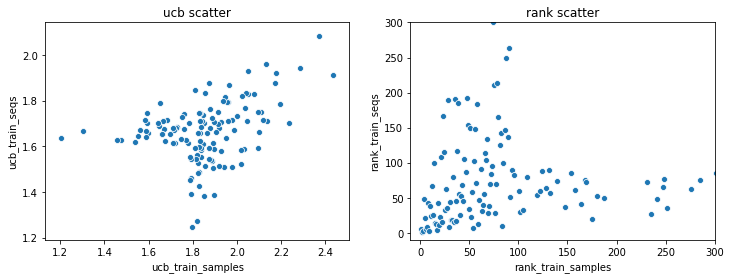

In [37]:
scatterplot_union_ucb_scores(ucb_train_samples, ucb_train_seqs, 'train_samples', 'train_seqs')

### Train samples with alpha 0.1 vs alpha 6

with same other parameters (kernel_name='WD_Kernel_Shift', l=6, s=1, embedding='label', rec_size=None, beta=1)

we can see changing the alpha value changes the predicted ucb for low predictions a lot. 

union set size:  141


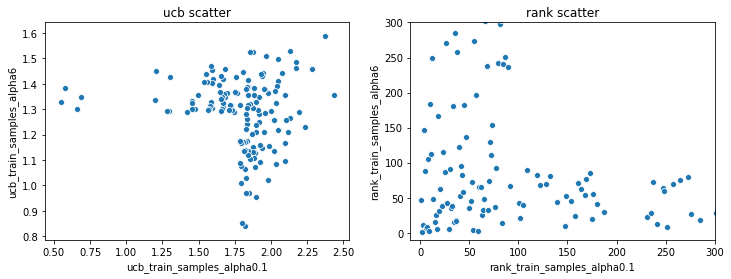

In [38]:
scatterplot_union_ucb_scores(ucb_train_samples, ucb_train_samples_alpha6, 'train_samples_alpha0.1', 'train_samples_alpha6')